# Trabalho final curso de redes complexas

### Preparando os dados

In [26]:
# Unquoting data 
from urllib.parse import unquote

files = ['links', 'categories', 'paths_finished']

for i in files:
    text_file = open(f'./my_data/wiki/{i}.csv', "r")
    data = text_file.read()
    text_file.close()

    unquoted_data = unquote(data)

    f = open(f'./my_data/wiki/{i}_unquoted.csv', "a")
    f.write(unquoted_data)
    f.close()


In [27]:
## Create dataframes from links file
import networkx as nx
import pandas as pd
import numpy as np

# Read the edge list from the file
df1 = pd.read_csv('./my_data/wiki/links_unquoted.csv', delimiter=';', header = None)

In [90]:
## Functions definitions

import matplotlib.pyplot as plt
from operator import itemgetter
#%matplotlib inline

def show_histogram(xvalues=None, yvalues=None, figsize=(5,5), xlabel='Values', ylabel='Count', title=''):
    h_deg = xvalues
    if xvalues == None:
        h_deg = list( range(0, len(yvalues)) )
    v_deg = yvalues
    if yvalues == None:
        v_deg = list( range(0, len(xvalues)) )
    plt.figure(figsize=figsize, tight_layout = True)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)    
    plt.title(title)
    plt.xticks(rotation = 60)
    plt.bar(h_deg, v_deg, color = 'g') 
    plt.show()

def histogram_attribute(graph, attr, title=''):
    categories_list = vectorize_attr(graph, attr)
    x = []

    for item in categories_list:
        if item not in [row[0] for row in x]:
            x.append((item, 1))
        else:
            idx = [row[0] for row in x].index(item)
            x[idx] = (item, x[idx][1]+1)

    x = sorted(x, key=itemgetter(1), reverse=True)
    print(x)

    show_histogram(yvalues=[row[1] for row in x], xvalues=[row[0] for row in x], figsize=(15,8), xlabel=f'{attr} count', ylabel=f'Pages with {attr}', title=title)

def vectorize_attr(graph, attr):
    node_attrs = nx.get_node_attributes(graph, name=attr)
    c = []
    for item in node_attrs:
        c = c + node_attrs[item]
    return c

## Hyperlinks on Wikipedia

Esta é uma rede de páginas da Wikipedia, onde os nós são páginas e as arestas representam hyperlinks entre duas páginas. É uma rede que representa um subconjunto da wikipedia, contendo 4096 páginas e 106647 links.
A rede foi criada para ser utilizada no jogo Wikispeedia, onde eram dadas aos jogadores uma página inicial e uma página alvo e os jogadores deveriam, partindo da página inicial, chegar à página alvo navegando pelos links entre as páginas.
Foram coletados dados dos caminhos percorridos pelos jogadores bem como os caminhos que não foram concluídos.
Cada página também contém os atributos categoria e macro-categoria, que classifica o conteúdo da página (história, química, música etc). 

Fonte: https://snap.stanford.edu/data/wikispeedia.html

### Montagem do grafo

Cada página será um nó e se uma página A contem um link para uma página B então é inserida uma aresta direcionada A -> B.
Porém o grafo é não direcionado devido à sessão de referências.
Cada nó possui os atributos **category** e **macrocategory** que são listas que classificam a página de acordo com o tema.

Exemplos de categorias e subcategorias:

 - **Página**: Brazil
   - **Category**: \[subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries ...\]
   - **MacroCategory**: \[Geography, Countries ...\]
 - **Página**: Albert_Einstein
   - **Category**: \[subject.People.Astronomers_and_physicists ... \]
   - **Macrocategory**: People

Assim, cada nó do grafo terá as seguintes propriedades:
  - *valor*: string
  - *grau*: inteiro
  - *atributos*
    - *categoria*: lista de strings
    - *macrocategoria*: lista de strings

In [29]:
## Mount graph

G = nx.Graph()
for i in range(len(df1)):
    G.add_node(df1.loc[i,0], label = df1.loc[i,0], category = [], macrocategory= []) # Add node A with -1 as attribute
    G.add_node(df1.loc[i,1], label = df1.loc[i,1], category = [], macrocategory= []) # Add node B with -1 as attribute
    G.add_edge(df1.loc[i,0], df1.loc[i,1])        # Add edge (A,B) to the network
    

## Add category property to nodes
df2 = pd.read_csv('./my_data/wiki/categories_unquoted.csv', delimiter=';', header = None)

for i in range(len(df2)):

    node_attrs_category = nx.get_node_attributes(G, name='category')
    node_attrs_macrocategory = nx.get_node_attributes(G, name='macrocategory')
    list_category = []
    list_macrocategory = []
    if df2.loc[i,0] in node_attrs_category.keys() and node_attrs_category[df2.loc[i,0]] != None:
        list_category = list(node_attrs_category[df2.loc[i,0]])
        list_category.append(df2.loc[i,1])
        list_macrocategory = list(node_attrs_macrocategory[df2.loc[i,0]])
        list_macrocategory.append(df2.loc[i,1].split('.')[1])
    G.add_node(df2.loc[i,0], label = df2.loc[i,0], category = list_category, macrocategory = list(set(list_macrocategory)))

G.remove_edges_from( nx.selfloop_edges(G) )

## Giant component

In [30]:
## Has giant component?

Gcc = sorted( nx.connected_components(G), key=len, reverse=True)
print(f'Number of connected components: {len(Gcc)}')

#for idx in range(len(Gcc)):
#    print(f'Number of nodes of connected component {idx}: {G.subgraph( Gcc[idx] ).number_of_nodes()}')
#    print(f'Number of edges of connected component {idx}: {G.subgraph( Gcc[idx] ).number_of_edges()}')

# Make a subgraph "H" of "G" containing only the giant component, i.e. Gcc[0]
H = G.subgraph( Gcc[0] ).copy()

## Number of nodes and edges
print('Componente Gigante H:')
print("Number of nodes: %d" %H.number_of_nodes() )
print("Number of edges: %d" %H.number_of_edges() )
print(f'Average Degree: {sum([degree[1] for degree in H.degree()])/H.number_of_nodes()}')
sorted_degrees = sorted(H.degree(), key=itemgetter(1), reverse=True)
print(f'Max degree: {sorted_degrees[0][1]} in node {sorted_degrees[0][0]}')

Number of connected components: 13
Componente Gigante H:
Number of nodes: 4589
Number of edges: 106534
Average Degree: 46.430159076051424
Max degree: 1621 in node United_States


## Distribuição de categorias

Science
[('Science', 1103), ('Geography', 1063), ('People', 676), ('History', 525), ('Everyday_life', 367), ('Design_and_Technology', 246), ('Countries', 229), ('Citizenship', 215), ('Language_and_literature', 192), ('Religion', 131), ('Music', 96), ('Business_Studies', 87), ('IT', 82), ('Mathematics', 45), ('Art', 38)]


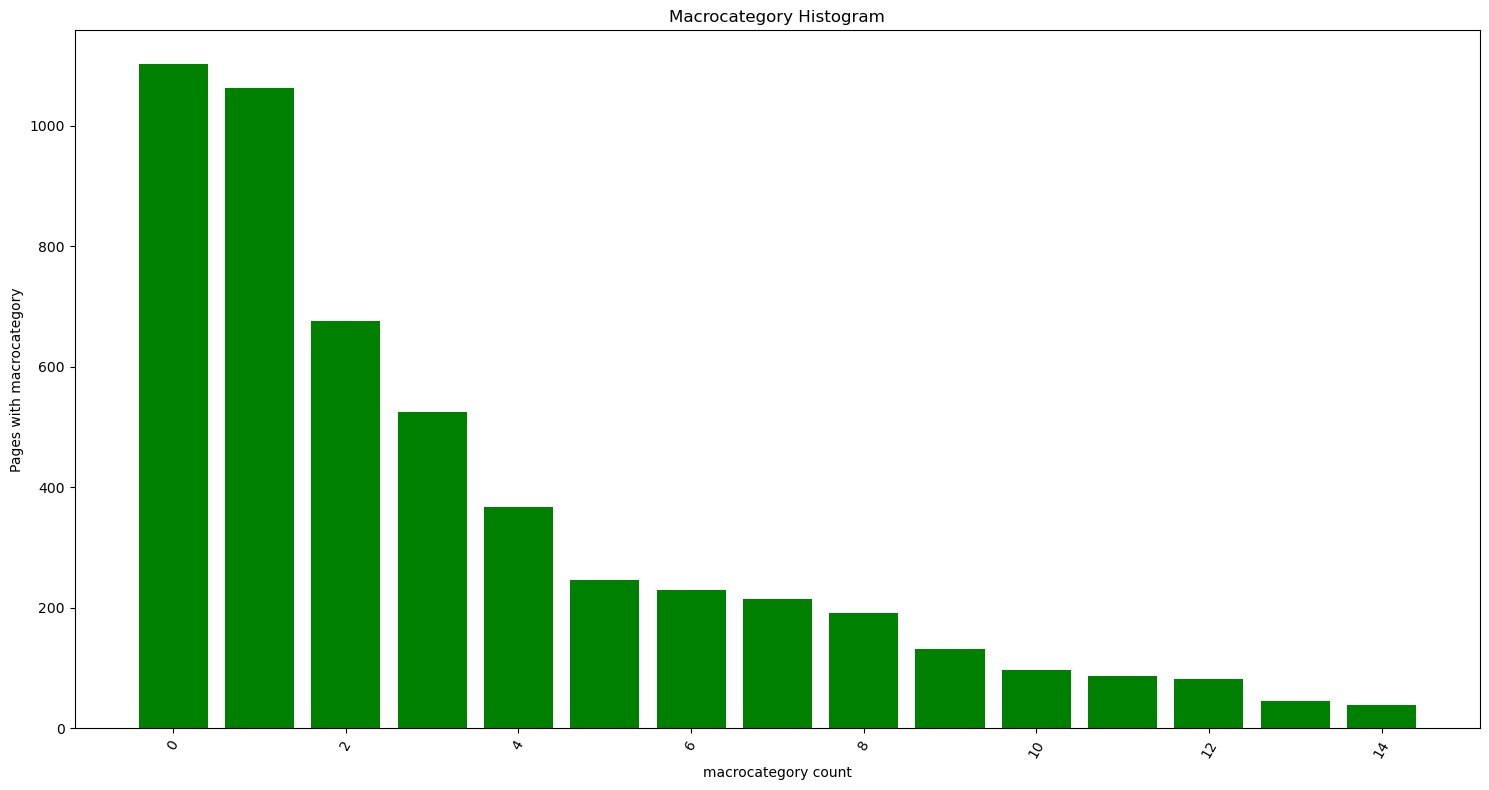

In [87]:
## Macro-Category distribution
from operator import itemgetter

histogram_attribute(H, 'macrocategory', title='Macrocategory Histogram')

subject.Countries
[('subject.Countries', 6183), ('subject.Science.Biology.Birds', 4347), ('subject.Geography.Geography_of_Great_Britain', 3348), ('subject.Science.Chemistry.Chemical_elements', 3213), ('subject.Science.Biology.Mammals', 3078), ('subject.People.Historical_figures', 2916), ('subject.Science.Biology.Plants', 2916), ('subject.Science.Biology.Health_and_medicine', 2916), ('subject.Science.Physics.Space_Astronomy', 2835), ('subject.Geography.North_American_Geography', 2781), ('subject.Citizenship.Politics_and_government', 2619), ('subject.Everyday_life.Food_and_agriculture', 2619), ('subject.History.Ancient_History_Classical_History_and_Mythology', 2349), ('subject.Design_and_Technology.Railway_transport', 2268), ('subject.Geography.European_Geography', 2241), ('subject.History.General_history', 2160), ('subject.Geography.African_Geography', 2160), ('subject.Geography.Geology_and_geophysics', 2052), ('subject.Design_and_Technology.Engineering', 1998), ('subject.History.Britis

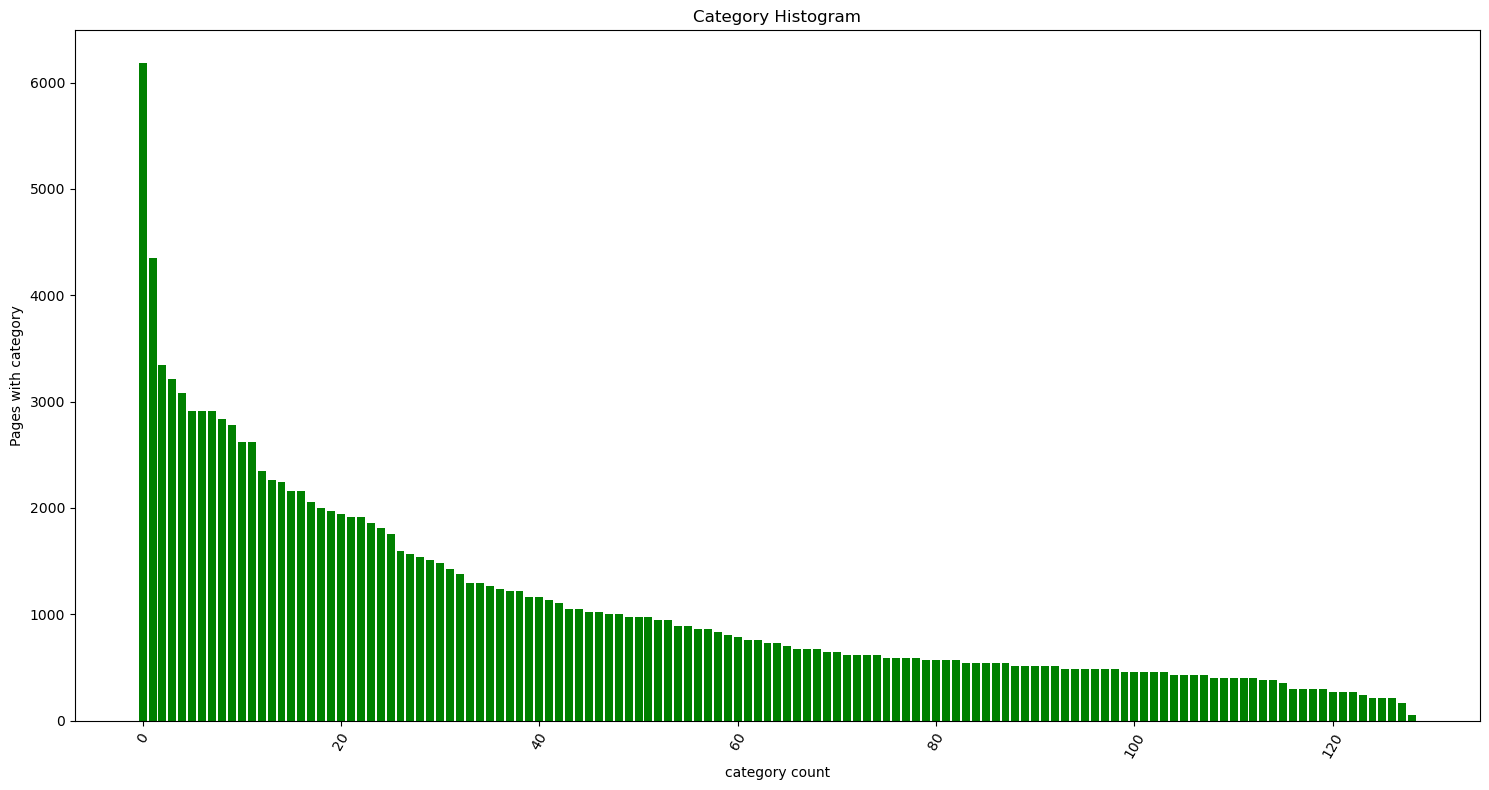

In [86]:
## Category distribution
histogram_attribute(H, 'category', title='Category Histogram')

## Degree Analisys

In [74]:
## Number of nodes and edges
print("Number of nodes: %d" %H.number_of_nodes() )
print("Number of edges: %d" %H.number_of_edges() )
print(f'Average Degree: {sum([degree[1] for degree in G.degree()])/H.number_of_nodes()}')
sorted_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)
print(f'Max degree: {sorted_degrees[0][1]} in node {sorted_degrees[0][0]}')

Number of nodes: 4589
Number of edges: 106534
Average Degree: 46.43277402484201
Max degree: 1621 in node United_States


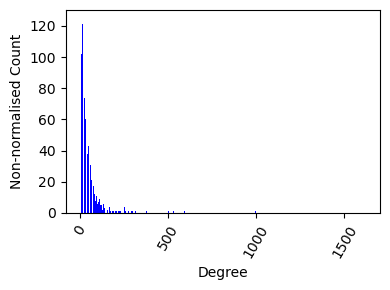

In [34]:
# Plot the degree distribution
show_histogram(yvalues=nx.degree_histogram(H), figsize = (4,3), ylabel='Non-normalised Count', xlabel='Degree')


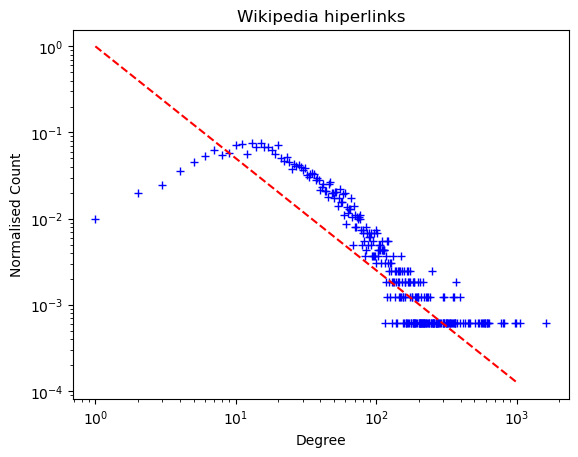

In [168]:
## Degree distribution (log)
import networkx as nx
import matplotlib.pyplot as plt

def log_view_from_graph(H):
    l = nx.degree_histogram(H)                              # calculate the degree histogram
    log_view_from_list(l)

def log_view_from_list(l):
    h_deg = l                              # calculate the degree histogram
    h_deg_n = [x / len(l) for x in h_deg]        # normalise the histogram to make a pdf
    v_deg = list( range(0,len(h_deg)))                          # create a list of degree values, from 0 to len(h_deg)

    # Draw the histogram, using log-scale on the axes (why? try without log-scale)
    plt.title('Wikipedia hiperlinks')
    plt.ylabel('Normalised Count')
    plt.xlabel('Degree')
    plt.yscale('log')
    plt.xscale('log')
    #plt.bar(v_deg, h_deg_n, width=0.8, color='b')  # this plot using "bars", but "bars" are not good when using log-scale in the axes - DO NOT USE IT UNLESS THE HISTOGRAM IS SMALL!
    plt.plot(v_deg, h_deg_n, 'b+')

    # Draw an eye-guide curve. In this case a power-law with exponent 1.8
    list_x = list( range(1,1000) )                    # Create the values for the x-axis and convert to a list
    list_y = list( [ 1/(i**1.3) for i in list_x ] )   # Create the values for the y-axis and convert to a list:
                                                    # this code is called "list comprehension" [ 1/(i**1.8) for i in list_x ] -> for each item "i" in the list "list_x", the output is "1/(i**1.8)"
    plt.plot(list_x, list_y, 'r--')

    plt.show()

log_view_from_graph(H)


A rede possui um componente gigante com 4589 nós. Isso representa aproximadamente 99.86% da rede. Portanto, de agora em diante, usaremos o componente gigante para calcular as demais métricas.

## Centrality metrics

In [36]:
## Centrality metrics
# Some solutions

# Calculate the relevant network measures and organise the data into a dataframe

# Degree centrality -> that is the same as the degree but normalised by N-1
k_cent = nx.degree_centrality(H)

# Betweenness centrality -> normalised by 2/((n-1)(n-2))
b_cent = nx.betweenness_centrality(H)

# Page-Rank centrality
pr_cent = nx.pagerank(H)

# Eigenvector centrality
# but the network in undirected! therefore, better to use eigenvector centrality
# note that the method nx.pagerank() above works with undirected network by assuming that all edges are bidirectional
ev_cent = nx.eigenvector_centrality(H)

# clustering coefficient of each node
cc = nx.clustering(H)

# Save the network measures of each node, that is originally in a dictionary, to dataframes
df1 = pd.DataFrame.from_dict(k_cent, orient='index', columns = ['degree'])
df2 = pd.DataFrame.from_dict(b_cent, orient='index', columns = ['betweenness'])
df3 = pd.DataFrame.from_dict(ev_cent, orient='index', columns = ['eigenvector'])
df4 = pd.DataFrame.from_dict(cc, orient='index', columns = ['clustering'])

# Save the attributes of each node, that are originally stored as node attributes, in dataframes
# Note that here I include the node column to make sure the index will store the node ID
df5 = pd.DataFrame( list(H.nodes(data = 'category') ), columns = ['node','category'])
df5 = df5.set_index('node')


# Combine all dataframes into a single dataframe
network_measures = pd.concat([df1, df2, df3, df4, df5], axis = 1)

pd.set_option('display.max_rows', 20)

network_measures

,degree,betweenness,eigenvector,clustering,category
Áedán_mac_Gabráin,0.002398,1.473365e-06,0.001728,0.581818,[subject.History.British_History.British_Histo...
Bede,0.008065,8.202625e-05,0.003519,0.144144,[subject.History.British_History.British_Histo...
Columba,0.004359,1.141426e-05,0.002519,0.294737,"[subject.People.Religious_figures_and_leaders,..."
Dál_Riata,0.006321,2.689838e-05,0.003020,0.273399,[subject.History.British_History.British_Histo...
Great_Britain,0.044246,2.412929e-03,0.030650,0.068819,"[subject.History.British_History, subject.Citi..."
...,...,...,...,...,...
Yellowhammer,0.002833,1.711574e-05,0.002873,0.282051,"[subject.Science.Biology.Birds, subject.Scienc..."
Yotsuya_Kaidan,0.000436,0.000000e+00,0.000275,1.000000,[subject.Language_and_literature.General_Liter...
You're_Still_the_One,0.000436,4.637280e-08,0.000279,0.000000,[subject.Music.Musical_Recordings_and_composit...
"Yungay,_Peru",0.000872,7.692585e-08,0.000792,0.666667,[subject.Geography.Central_and_South_American_...


In [117]:
list(dict(H.degree()).values())

[11,
 37,
 20,
 29,
 203,
 360,
 84,
 175,
 54,
 38,
 394,
 195,
 19,
 367,
 87,
 50,
 299,
 108,
 305,
 204,
 121,
 254,
 39,
 107,
 94,
 559,
 57,
 349,
 364,
 195,
 1046,
 771,
 20,
 39,
 92,
 23,
 43,
 65,
 979,
 18,
 794,
 38,
 580,
 18,
 395,
 101,
 363,
 48,
 47,
 154,
 209,
 215,
 8,
 590,
 618,
 53,
 104,
 56,
 163,
 10,
 22,
 816,
 91,
 32,
 120,
 48,
 47,
 147,
 303,
 251,
 265,
 191,
 93,
 22,
 93,
 90,
 90,
 73,
 58,
 78,
 314,
 87,
 43,
 50,
 88,
 109,
 110,
 23,
 72,
 107,
 18,
 64,
 144,
 349,
 143,
 112,
 25,
 360,
 568,
 47,
 65,
 376,
 1621,
 88,
 80,
 61,
 85,
 84,
 94,
 132,
 84,
 167,
 45,
 99,
 23,
 630,
 58,
 67,
 317,
 131,
 200,
 311,
 125,
 75,
 112,
 113,
 95,
 135,
 185,
 192,
 239,
 415,
 64,
 51,
 187,
 42,
 47,
 60,
 72,
 68,
 86,
 77,
 23,
 34,
 536,
 77,
 31,
 27,
 37,
 37,
 98,
 107,
 18,
 17,
 76,
 143,
 28,
 461,
 123,
 40,
 23,
 181,
 23,
 31,
 72,
 42,
 190,
 153,
 291,
 45,
 37,
 31,
 28,
 174,
 15,
 21,
 89,
 214,
 453,
 37,
 167,
 109,
 52,
 99

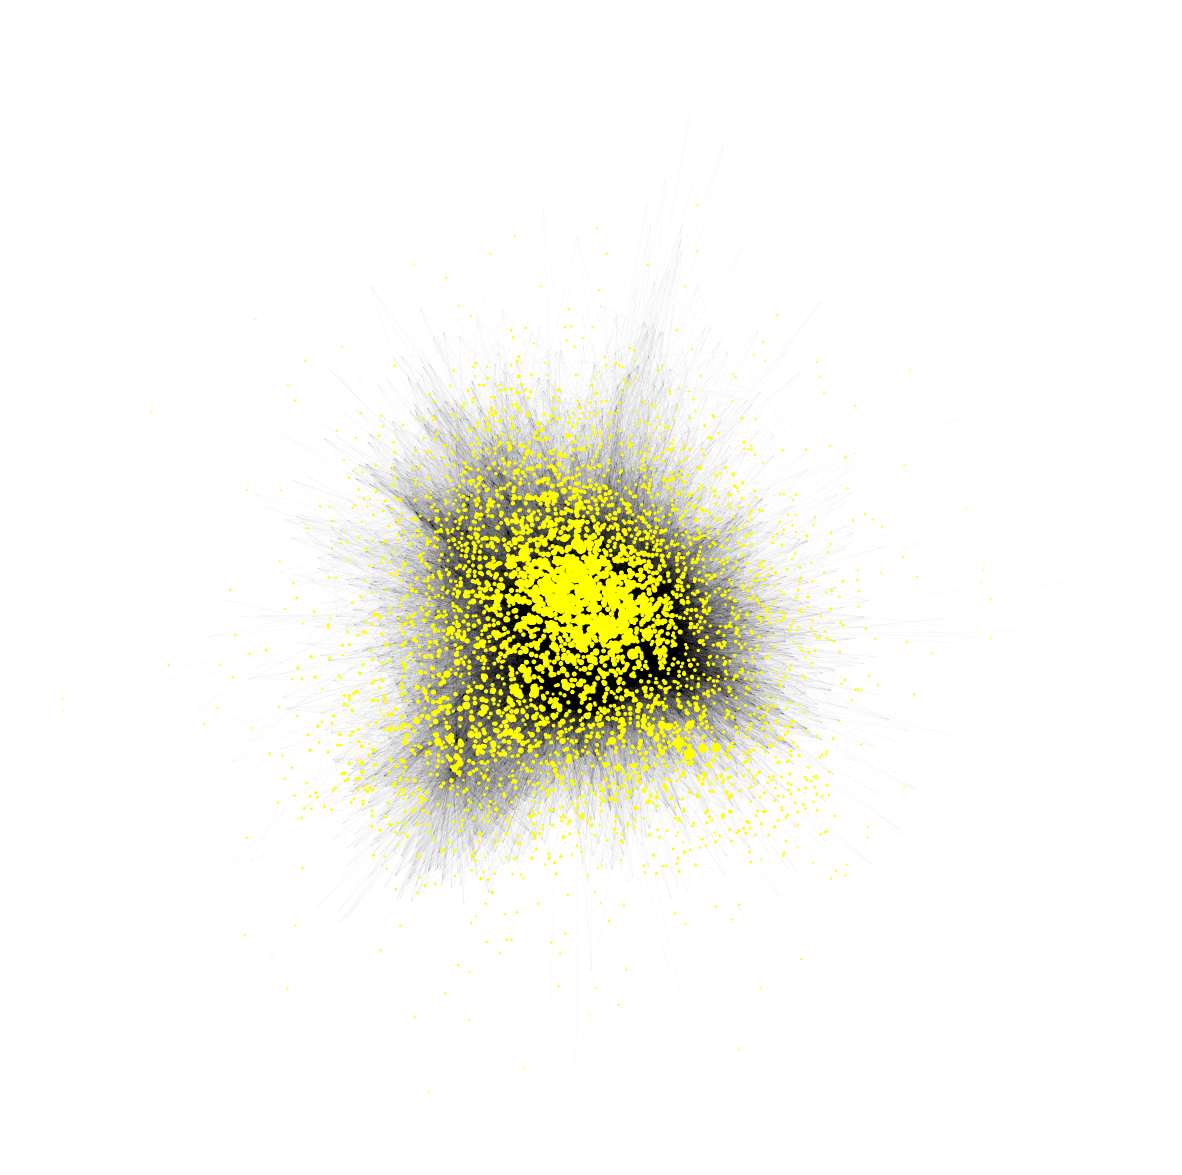

In [118]:
plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos = nx.spring_layout(H), node_size = [x/10 for x in list(dict(H.degree()).values()) ], node_color = "yellow")
nx.draw_networkx_edges(H, pos = nx.spring_layout(H), width=0.1, alpha=0.1)

#plt.xlim(-0.05, 1.05)
#plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.show()

## Assortativity

Essa rede é disassortativa em termos de grau. Ou seja, nós de grau menor tendem a se ligar a nós de grau maior.

In [208]:
# Assortativity by degree

# for undirected and unweighted networks
r_deg = nx.degree_assortativity_coefficient(H)
print('Assort. by degree: %.4f' % r_deg)

r_deg = nx.degree_assortativity_coefficient(G)
print('Assort. by degree: %.4f' % r_deg)

# Assortativity by category
#r_colour = nx.attribute_assortativity_coefficient(H, 'category')
#print('Assort. by category: %.2f' % r_colour)

# Assortativity by macrocategory


Assort. by degree: -0.1159
Assort. by degree: -0.1158


In [207]:
H2 = G.copy()
attrs2 = nx.get_node_attributes(H2, name='macrocategory')
for attr in attrs2.keys():
    attrs2[attr] = tuple(attrs2[attr])

nx.set_node_attributes(H2, attrs2, 'macrocategory')
r_colour = nx.attribute_assortativity_coefficient(H2, 'macrocategory')
print('Assort. by macrocategory: %.2f' % r_colour)

attrs2 = nx.get_node_attributes(H2, name='category')
for attr in attrs2.keys():
    attrs2[attr] = tuple(attrs2[attr])

nx.set_node_attributes(H2, attrs2, 'category')
r_colour = nx.attribute_assortativity_coefficient(H2, 'category')
print('Assort. by category: %.2f' % r_colour)


Assort. by macrocategory: 0.19
Assort. by category: 0.10


## Path based metrics

Diâmetro é o maior menor caminho da rede.

In [38]:
print('Diameter: ', nx.diameter(H) )
#print('Tamanho médio dos menores caminhos', nx.average_shortest_path_length(H))

Diameter:  5


## Cluster coefficient

In [39]:
import pandas as pd

print("avg. cc: %.3f" % nx.average_clustering(H) )

df1 = pd.DataFrame.from_dict(nx.clustering(H), orient='index', columns=['clustering'])
print(df1)

avg. cc: 0.274
                      clustering
Áedán_mac_Gabráin       0.581818
Bede                    0.144144
Columba                 0.294737
Dál_Riata               0.273399
Great_Britain           0.068819
...                          ...
Yellowhammer            0.282051
Yotsuya_Kaidan          1.000000
You're_Still_the_One    0.000000
Yungay,_Peru            0.666667
Zara_Yaqob              0.666667

[4589 rows x 1 columns]


## Other metrics

In [40]:
triangles = nx.triangles(H)
closeness = nx.closeness_centrality(H)
triangles = sorted([(key, triangles[key]) for key in triangles], key=itemgetter(1), reverse=True)
closeness = sorted([(key, closeness[key]) for key in closeness], key=itemgetter(1), reverse=True)

#print('Triangles: ', triangles)
#print('Closeness: ', closeness)
print('Transitivity: %.3f' % nx.transitivity(H))

Transitivity: 0.103


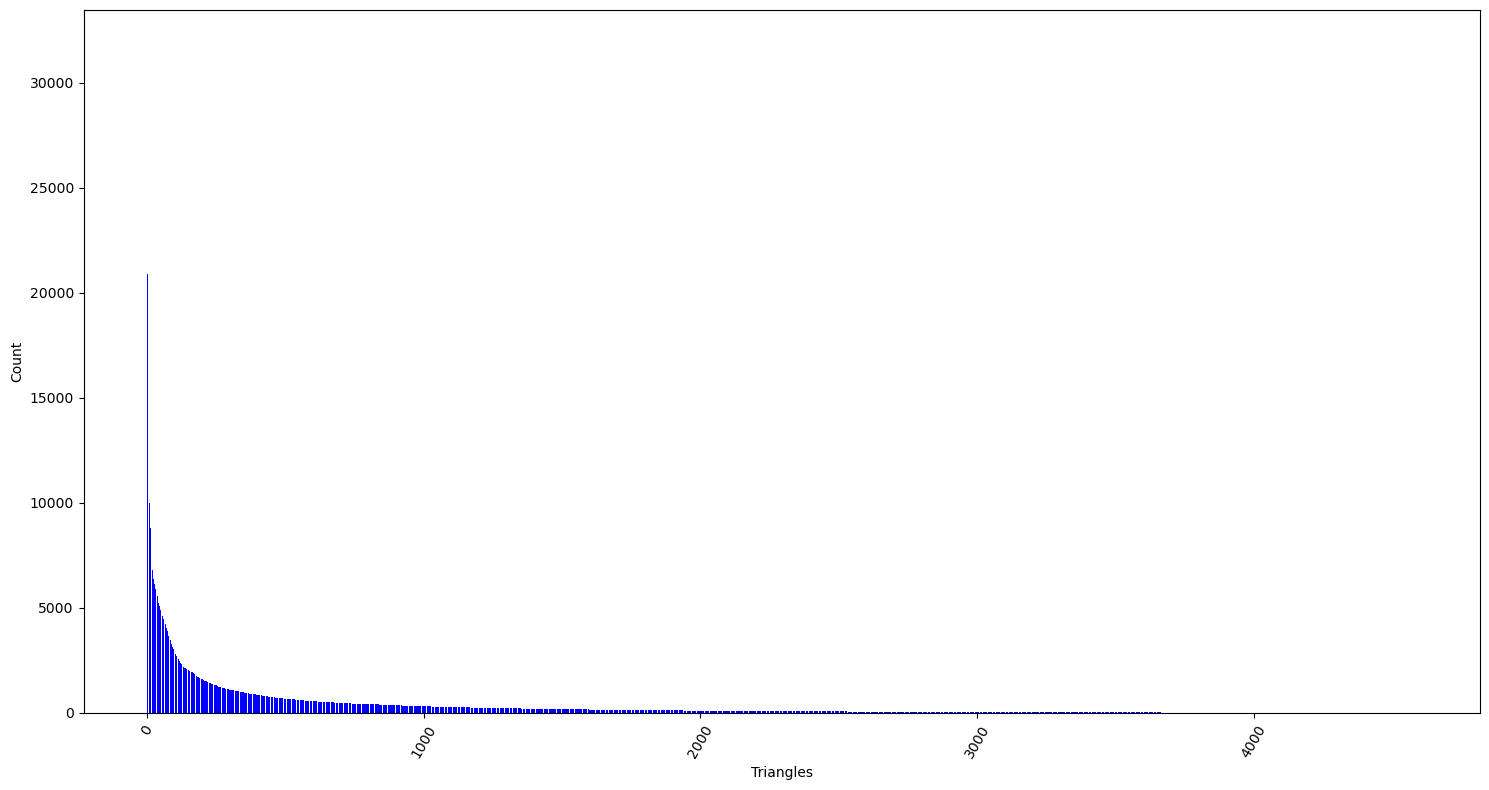

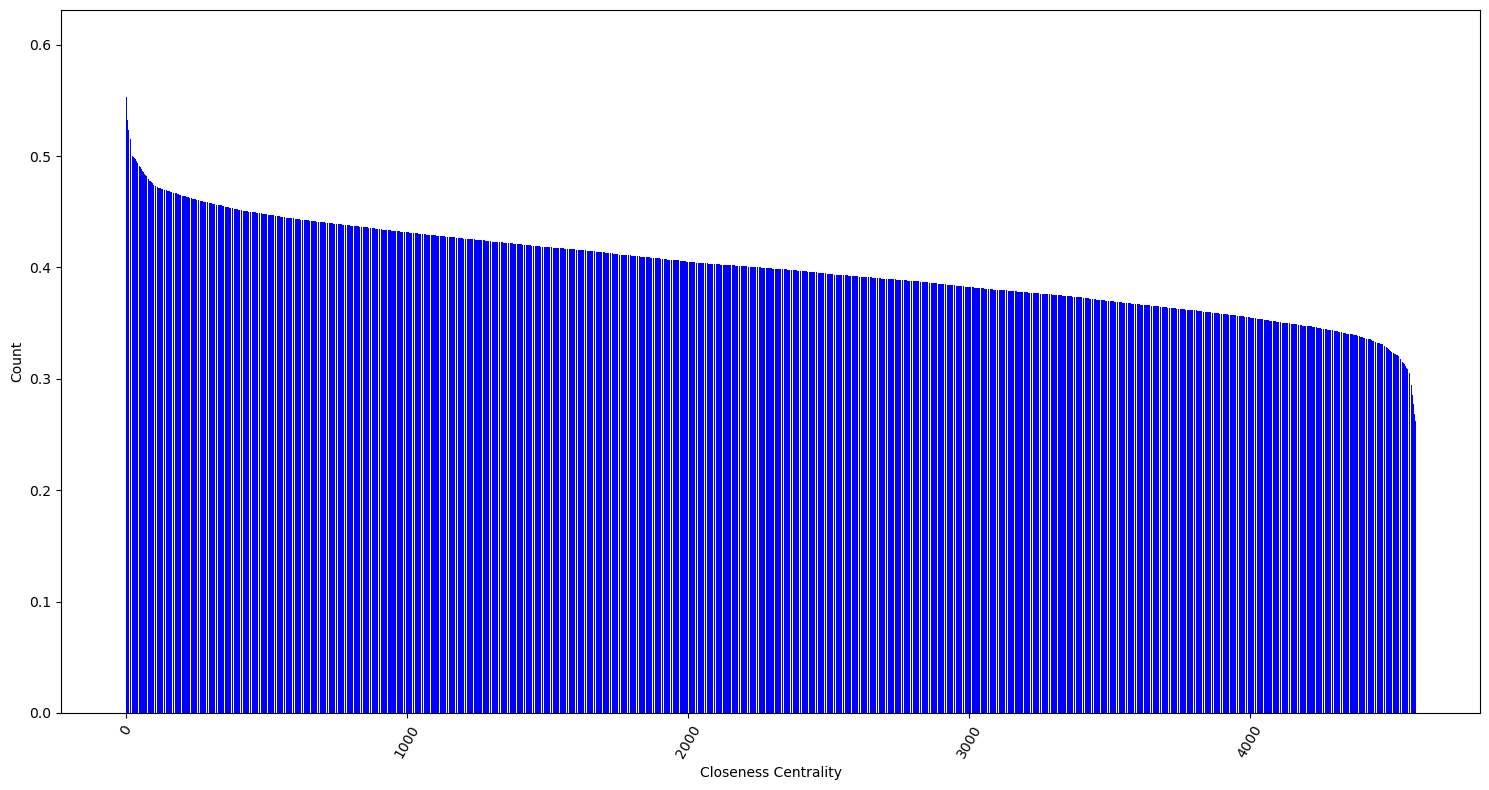

In [41]:
show_histogram(yvalues=[row[1] for row in triangles], figsize=(15,8), xlabel='Triangles')
show_histogram(yvalues=[row[1] for row in closeness], figsize=(15,8), xlabel='Closeness Centrality')

## K-Core

In [95]:
K = nx.k_core(H)
kb_cent = nx.betweenness_centrality(K)

Observa-se que algumas macro-categorias que eram predominantes na rede como um todo (imagem da célula 'Macro-Category distribution') não são tão predominantes no k-core.
Lá, a macrocategoria 'Science' era a predominandte, já no k-core, ela aparece em nono lugar.

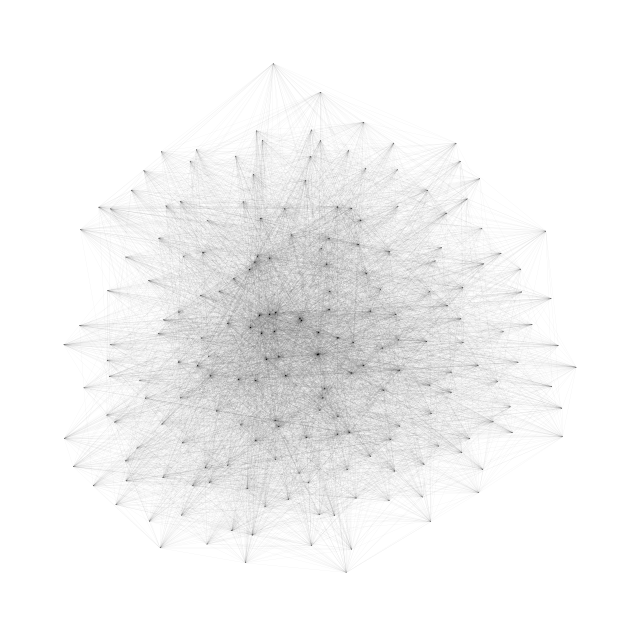

In [108]:


plt.figure(figsize=(8, 8))
#nx.draw_networkx_nodes(K, pos = nx.spring_layout(K), node_size = [x * 2000 for x in list(kb_cent.values()) ], node_color = "yellow")
nx.draw_networkx_edges(K, pos = nx.spring_layout(K), width=0.1, alpha=0.1)

#plt.xlim(-0.05, 1.05)
#plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.show()


In [112]:
len(K.nodes())

199

[('Geography', 156), ('Countries', 133), ('Citizenship', 15), ('History', 12), ('Language_and_literature', 5), ('Business_Studies', 5), ('Religion', 3), ('Everyday_life', 3), ('Science', 1), ('People', 1), ('Design_and_Technology', 1)]


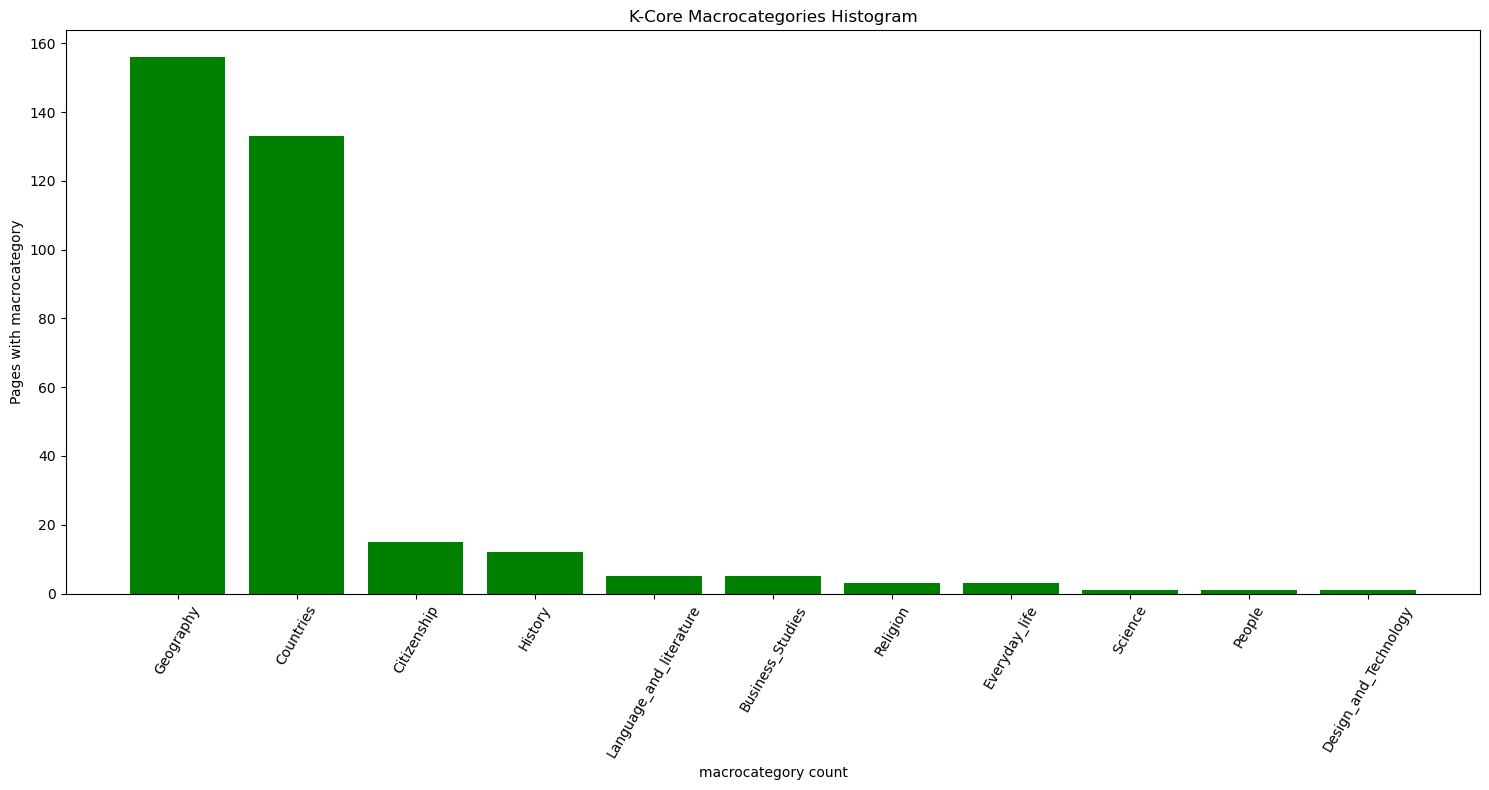

In [110]:
histogram_attribute(K, 'macrocategory', title='K-Core Macrocategories Histogram')
#histogram_attribute(H, 'category')

## Menores caminhos vs Caminhos dos Jogadores

In [44]:
## Load players paths dataframe
df3 = pd.read_csv('./my_data/wiki/paths_finished_unquoted.csv', delimiter=';', header = None)
df3

## Get all player paths and all origin/destiny pairs solved by the players
all_players_paths_1 = [row.split('|') for row in df3[3].tolist()]
all_players_pairs = set([(row[0], row[len(row)-1]) for row in all_players_paths_1])

all_players_paths = []
for path in all_players_paths_1:
    path_2 = []
    for node in path:
        if node != '<':
            path_2.append(node)
        else:
            path_2.pop()
    all_players_paths.append(path_2)


In [130]:
## Get all shortest paths for the origin/destiny pairs solved by the players
all_shortest_paths_tested = []
appthcp = all_players_paths.copy()
apprcp = all_players_pairs.copy()

for pair in all_players_pairs:
    try:
        sp = nx.shortest_path(H, source=pair[0], target=pair[1])
        if sp not in all_shortest_paths_tested:
            all_shortest_paths_tested.append(sp)
    except:
        apprcp.remove(pair)
        for p in appthcp:
            if p[0] == pair[0] and p[len(p)-1] == pair[1]:
                all_players_paths.remove(p)

len(all_shortest_paths_tested)

28717

In [121]:
print(len(all_players_paths))
print(len(all_shortest_paths_tested))

410536
28717


In [46]:
## Mean length of the paths (players and shotests)
length_shortest_paths = [len(row) for row in all_shortest_paths_tested]
length_players_paths = [len(row) for row in all_players_paths]
mean_shortest_paths_length = sum(length_shortest_paths)/len(length_shortest_paths)
mean_players_paths_length = sum(length_players_paths)/len(length_players_paths)

print(f'Tamanho médio dos menores caminhos: {mean_shortest_paths_length}')
print(f'Tamanho médio dos caminhos feitos pelos jogadores: {mean_players_paths_length}')

Tamanho médio dos menores caminhos: 3.3392763868092072
Tamanho médio dos caminhos feitos pelos jogadores: 5.956193853888575


In [47]:
## Size of the longer path (players and shotests)
print(f'Tamanho do maior menor caminho: {max(length_shortest_paths)}')
print(f'Tamanho do maior caminho feito por um jogador: {max(length_players_paths)}')

Tamanho do maior menor caminho: 5
Tamanho do maior caminho feito por um jogador: 405


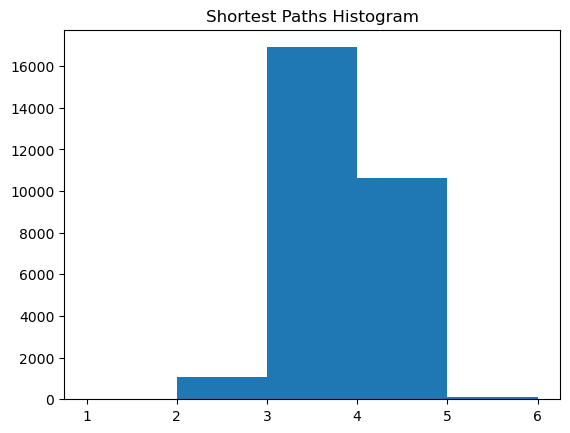

In [131]:
## Histogram for the length of the shortest paths
plt.hist(np.array(length_shortest_paths), bins=[1, 2, 3, 4, 5, 6])
plt.title('Shortest Paths Histogram')
plt.show()

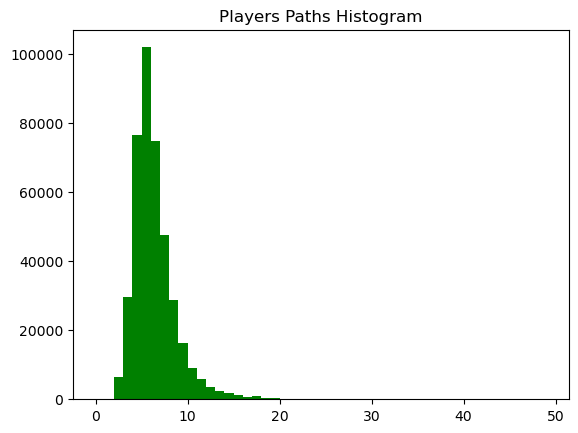

In [134]:
## Histogram for the length of the players paths
plt.hist(np.array(length_players_paths), bins=range(0,50), color = 'g')
plt.title('Players Paths Histogram')

plt.show()

In [50]:
import statistics as st

print(f'Moda do tamanho dos menores caminhos: {st.mode(length_shortest_paths)}')
print(f'Moda do tamanho dos caminhos dos jogadores: {st.mode(length_players_paths)}')

Moda do tamanho dos menores caminhos: 3
Moda do tamanho dos caminhos dos jogadores: 5


Esses dados mostram que geralmente, para um dado par de nós origem/destino, os caminhos percorridos pelos jogadores são maiores que o menor caminho possível. 

### Em termos de macro-categoria

Usaremos uma medida denominada **Coeficiente de Diversidade de Atributo (CDA)**, para quantificar o quanto o valor de um atributo varia ao longo do caminho.
A análise será feita para o atributo macrocategoria, ou seja, vamos analisar o quanto a macrocategoria varia ao longo das páginas do caminho, tanto para os menores caminhos como para os caminhos feitos pelos jogadores.


Seja uma rede na qual cada nó possui um atributo chamado '*x*' no formato de uma lista de valores.

Seja um caminho *P* o caminho entre dois nós quaisquer na rede.

Seja:
 - **V** - o conjunto de valores de que um atributo assumiu ao longo do caminho *P* (sem valores repetidos).
 - **nV** - o número de elementos em *V*
 - **A** - a lista de atributos dos nós que compõem o caminho *P* (com valores repetidos).
 - **nA** - o número de elementos em *A*
 - **nP** - o número de nós que compõem o caminho *P*

O **Coeficiente de Diversidade do Atributo** *x* no caminho *P* é dados por:

$$
cda = \log_{nP} \dfrac{nV}{nA}nP
$$

O *cda* é um valor entre 0 e 1, onde quanto mais próximo de zero menor é a variedade de valores do atributo ao longo do caminho, já quanto mais próximo de um, maior é a variedade.

No nosso exemplo, utilizando o atributo *macrocategoria*, quanto mais próximo de zero for o *cda* mais semelhantes são as macrocategorias dos nós que compõem um determinado caminho.
Já quanto mais próximo de um for o *cda* maior é a variedade de macrocategorias dos nós que compõem o caminho.

In [51]:
## Shortest paths

import math

def get_attributes_of_path(graph, path, attribute):
    path_attrs = []
    for node in path:
        if graph.has_node(node):
            attriute_values = nx.get_node_attributes(graph, name=attribute)[node]
            if attriute_values != None:
                path_attrs = path_attrs + attriute_values
    return path_attrs

def ratio_attribute_hops(attributes_list, path):
    return (len(set(attributes_list))/len(attributes_list))*len(path)
    
def get_cda_for_paths(graph, paths, attribute):
    cda_list = []
    for path in paths: 
        try:
            rah = ratio_attribute_hops(get_attributes_of_path(graph, path, attribute), path)
            if rah == 1:
                cda_list.append(0)
            else: 
                cda_list.append(math.log(rah, len(path)))
        except:
            print('exception')
    return cda_list
    

In [52]:
shortest_path_cda_list = get_cda_for_paths(H, all_shortest_paths_tested, 'macrocategory')

In [53]:
player_path_cda_list = get_cda_for_paths(H, all_players_paths, 'macrocategory')

In [54]:
print(f'CDA médio dos menores caminhos: {st.mean(shortest_path_cda_list)}')
print(f'CDA médio dos caminhos dos jogadores: {st.mean(player_path_cda_list)}')

CDA médio dos menores caminhos: 0.750807907040565
CDA médio dos caminhos dos jogadores: 0.6254091759584215


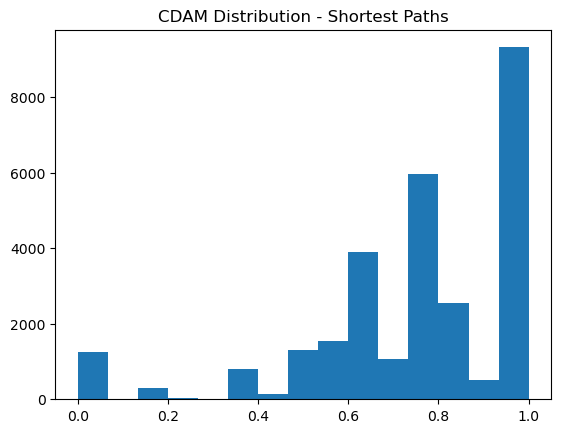

In [173]:
## Histogram for RAH of the shortest paths
plt.hist(np.array(shortest_path_cda_list), bins=15)
plt.title('CDAM Distribution - Shortest Paths')
plt.show()

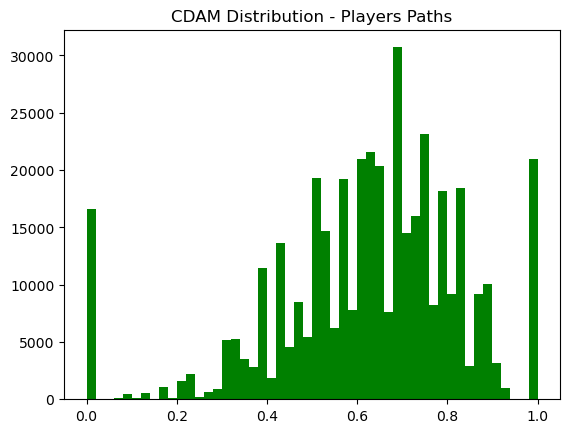

In [175]:
## Histogram for RAH of players paths
plt.hist(np.array(player_path_cda_list), bins=50, color='g')
plt.title('CDAM Distribution - Players Paths')
plt.show()

In [57]:
## Node with higher betweness
network_measures['betweenness']
network_measures.loc[network_measures['betweenness'].idxmax()]

degree                                                  0.353313
betweenness                                              0.12538
eigenvector                                             0.179683
clustering                                              0.024281
category       [subject.Countries, subject.Geography.North_Am...
Name: United_States, dtype: object

In [58]:
sp_vec = []
for i in all_shortest_paths_tested:
    sp_vec = sp_vec + i

pl_vec = []
for i in all_players_paths:
    pl_vec = pl_vec + i

In [176]:
print(st.mode(sp_vec))
print(st.mode(pl_vec))

United_States
United_States


In [192]:
print(len(sp_vec))
print(len(pl_vec))

95894
2445232


In [179]:
def distr(l):
    x = {}
    for i in l:
        if i in x.keys():
            x[i] = x[i] + 1
        else:
            x[i] = 0
    return x

In [193]:
sp_vec_dict = distr(sp_vec)
pl_vec_dict = distr(pl_vec)

sorted_sp_vec = sorted(sp_vec_dict.items(), key=lambda x:x[1], reverse=True)
print(sorted_sp_vec)

sorted_pl_vec = sorted(pl_vec_dict.items(), key=lambda x:x[1], reverse=True)
print(sorted_pl_vec)

[('United_States', 2965), ('United_Kingdom', 2739), ('France', 1865), ('World_War_II', 1304), ('Russia', 1220), ('20th_century', 1045), ('Germany', 866), ('England', 838), ('Scotland', 786), ('English_language', 749), ('Ireland', 724), ('Canada', 704), ('Europe', 696), ('Italy', 520), ('European_Union', 504), ('Currency', 474), ('Australia', 462), ('India', 458), ('Africa', 437), ('Animal', 425), ('Sweden', 425), ('China', 424), ('Great_Britain', 409), ('Time_zone', 353), ('Earth', 349), ('Japan', 349), ('19th_century', 349), ('North_America', 336), ('Atlantic_Ocean', 309), ('Water', 308), ('Paris', 284), ('Asia', 262), ('Finland', 255), ('Monarchy', 253), ('Sun', 250), ('Adolf_Hitler', 245), ('Spain', 241), ('Latin', 229), ('Human', 211), ('Netherlands', 209), ('Soviet_Union', 203), ('Washington,_D.C.', 188), ('Athens', 187), ('Wales', 185), ('Tourism', 183), ('Greece', 181), ('21st_century', 178), ('Computer', 175), ('Solar_System', 173), ('London', 171), ('Egypt', 162), ('Mexico', 1

In [60]:
print('Tamanho médio dos menores caminhos', nx.average_shortest_path_length(H))

Tamanho médio dos menores caminhos 2.5253455678384857


In [199]:
df2.sort_values('betweenness', ascending=False).head(10)

,betweenness
United_States,0.125380
United_Kingdom,0.047449
Europe,0.044716
France,0.036858
England,0.033641
World_War_II,0.025599
Germany,0.023159
English_language,0.020243
Africa,0.019874
London,0.019031
